In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from PIL import Image
from glob import glob
import sklearn
import pickle


In [2]:
#load all the models
haar = cv2.CascadeClassifier('./Model/haarcascade_frontalface_default.xml')
#pickle files
mean = pickle.load(open('./Model/mean_preprocess.pickle','rb'))
model_svm = pickle.load(open('./Model/model_svm.pickle','rb'))
model_pca = pickle.load(open('./Model/pca_50.pickel','rb'))
print('Model Loaded Successfully')

Model Loaded Successfully


In [3]:
gender_pre=['Male','Female']
font=cv2.FONT_HERSHEY_SIMPLEX

In [4]:
#test data
test_data_path='./data/male_000281.jpg'
color='bgr'
#step 1: read image
img=cv2.imread(test_data_path)

def pipeline_model(img,color='rgb'):
    
#step 2: convert into gray scale
    if color == 'bgr':
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    #step 3: crop the face using haar cascade classifier
    faces=haar.detectMultiScale(gray,1.5,3)
    for x,y,w,h in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2) #drawing rectangle
        roi=gray[y:y+h,x:x+h] #crop image

#step 4: normalization (0-1)
        roi=roi/255.0

#step 5: resize images into 100x100
        if roi.shape[1]>100:
            roi_resize=cv2.resize(roi,(100,100),cv2.INTER_AREA)
        else:
            roi_resize=cv2.resize(roi,(100,100),cv2.INTER_CUBIC)

#step 6: Flattening (1x10,000)
        roi_reshape=roi_resize.reshape(1,10000)
    
#step 7: Substract with mean
        roi_mean=roi_reshape-mean

#step 8: Get eigen image
        eigen_image=model_pca.transform(roi_mean)

#step 9: Pass to ML Model (SVM)
        results=model_svm.predict_proba(eigen_image)[0]
    
#step 10: 
        predict=results.argmax() #0 or 1
        score=results[predict]
    
#step 11:
        text="%s : %0.2f"%(gender_pre[predict],score)
        cv2.putText(img,text,(x,y),font,1,(0,255,0),2)
    return img


In [5]:
from PIL import Image


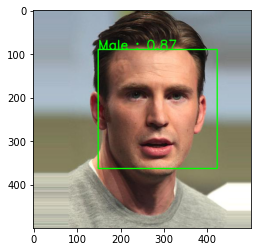

In [6]:
test_data_path='./data/male_000281.jpg'
color='bgr'
#step 1: Read Image
img = Image.open(test_data_path) #rgb
#step 2: Convert into array
img=np.array(img)
#step 3: Pass to Pipeline Model
img=pipeline_model(img)
plt.imshow(img)

# Apply pipeline model to video

In [7]:
cap=cv2.VideoCapture('./data/video.mp4')
while True:
    ret, frame=cap.read()
    
    if ret==False:
        break
    
    frame=pipeline_model(frame,color='bgr')
        
    cv2.imshow('Gender Detector',frame)
    if cv2.waitKey(10)==ord('s'): #press s to exit
        break
        
cv2.destroyAllWindows
cap.release()